**HolidayCheck Case Study**
Guardian Media API - Datenanalyse über artikel von Justin trudeau

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime as dt
from datetime import date
from wordcloud import WordCloud, STOPWORDS

### Aufgabe 1 (Abfrage)
***
Im ersten Schritt habe ich über das request Modul die Verbindung zur Guardian Media API hergestellt. Ich habe in diesem öffentliche Notebook den API Key "test".

**Challenge:**
- Die Schnittstelle liefert nur begrenzte Ergebnisse pro Abfrage
- Die Requests werden bei einer zu schnellen Abfragerate blockiert

**Lösung:**
- Mehrere Iterationen durch die verschiedenen Ergebnisseiten
- Time.sleep Modul, um die Schnittstelle nicht zu überfordern

**Ergebnis:**

- Ein Dataframe (*df_guardian*), welches alle Publikationen seit dem 01.01.2018 enthält, welche den Namen "Justin Trudeau" eischliessen. 

In [3]:
# Task 1 - extract the information about Justin Trudeau since 01.01.2018

url = 'https://content.guardianapis.com/search'
search_term = 'Justin Trudeau'
date_today = date.today().strftime("%Y-%m-%d")

params = {'api-key':'test',
            'page-size':50, #Page Size 100 or 200 caused an error.
            'q':search_term,
            'from-date': "2018-01-01",
            'to-date': date_today,
            'page': 1
        }

def query_api(url, params):
    """
    Function to query the Guardian API with the preffered search term. 
    The output is a int with the amount of results and a string with the actual date and the amount of results to verify.
    """
    response = requests.get(url, params)
    return response.json()

json_result = query_api(url, params)
print('On the ' + date_today + ', we found ' + str(json_result['response']['total']) + ' results with the search term ' + search_term +'.')

def query_all_articles(url, params):
    """
    Function to iterate trough all the results/pages from the query and add the results to one dataframe.
    The function adds at the params dict "page" in every iteration +1, to go trough every page automated. 
    """
    df = pd.DataFrame(columns=['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate', 'webTitle', 'webUrl', 'apiUrl','fields','isHosted','pillarId','pillarName'])

    if int(json_result['response']['total']) > 200:
        for i in range(0, (int((json_result['response']['total']) / int(params['page-size']) + 1))):
            print('Iterate through page number ' + str(params['page'])) #To check the iterations
            data = pd.DataFrame(query_api(url, params)['response']['results'])
            df = pd.concat([df, data])
            params['page'] = int(params['page']) + 1
            time.sleep(3)
                

    return df

df_guardian = query_all_articles(url, params)



On the 2023-01-09, we found 8215 results with the search term Justin Trudeau.
Iterate through page number 1
Iterate through page number 2
Iterate through page number 3
Iterate through page number 4
Iterate through page number 5
Iterate through page number 6
Iterate through page number 7
Iterate through page number 8
Iterate through page number 9
Iterate through page number 10
Iterate through page number 11
Iterate through page number 12
Iterate through page number 13
Iterate through page number 14
Iterate through page number 15
Iterate through page number 16
Iterate through page number 17
Iterate through page number 18
Iterate through page number 19
Iterate through page number 20
Iterate through page number 21
Iterate through page number 22
Iterate through page number 23
Iterate through page number 24
Iterate through page number 25
Iterate through page number 26
Iterate through page number 27
Iterate through page number 28
Iterate through page number 29
Iterate through page number 30
I

### Aufgabe 1.1 (Reinigung)
***
Im zweiten Schritt habe ich die Daten vor der Weiterverarbeitung gereinigt 

**Challenge:**
- Wir arbeiten mit Zeitdaten (webPublicationDate)
- Es gibt mehrere Duplikate im Datensatz, es muss entschieden werden wie wir damit fortfahren.
- Es gibt Null / NaN Werte im Datensatz 

**Lösung:**
- Die Datumsspalte (webPublicationDate) zu einem Pandas "datetime" format abändern
- Die Duplikate identifizieren und entfernen, da es sich um Daten mit demselben Titel und derselben API Url handelt und diese unsere Analyse verfälschen würden. 
- Die Spalte mit den Null / NaN Werten löschen, da wir diese Spalte nicht benötigen, macht es in diesem speziellen Fall keinen Sinn ihr weitere Beachtung zu schenken. 

**Ergebnis:**

- Ein Dataframe (*df_cleaned*) mit allen Spalten (*'type', 'sectionId', 'sectionName', 'webTitle'*), welche wir zu Beginn benötigen. 

In [4]:
# Check & clean the data
df_guardian.info() 

# 8212 rows, 12 columns
df_guardian.shape

# All datatypes are objects --> I wil lchange the 'webPublicationDate" to datetime format and set as index for a easier data handling
df_guardian.dtypes

df_guardian['webPublicationDate'] = pd.to_datetime(df_guardian['webPublicationDate']).dt.strftime("%Y-%m-%d")
df_guardian = df_guardian.set_index('webPublicationDate')

# I have found 20 row duplicates --> I will delete it
df_guardian[df_guardian.duplicated()].count()
df_guardian.drop_duplicates(inplace = True)

# I have found 55 duplicates with the same webTitle --> I will delete it, beacuse the most of them are "Correction and clarification" or Football preview articles
dup_webtitle = df_guardian.loc[:, 'webTitle'][df_guardian.loc[:, 'webTitle'].duplicated()]
df_guardian.drop_duplicates(subset=['webTitle'], inplace = True)

# I have found 8265 NaN Values in the column "field" --> I don't need this column, I will delete it
df_guardian.isna().sum()

# I have found 8265 Null Values in the column "field" --> I don't need this column, I will delete it
df_guardian.isnull().sum()

# For the tasks, I need just the columns type, sectionID, sectionName, webPucblication, webTitle
df_cleaned = df_guardian.loc[:, ['type', 'sectionId', 'sectionName', 'webTitle']]

df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8215 entries, 0 to 14
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  8215 non-null   object
 1   type                8215 non-null   object
 2   sectionId           8215 non-null   object
 3   sectionName         8215 non-null   object
 4   webPublicationDate  8215 non-null   object
 5   webTitle            8215 non-null   object
 6   webUrl              8215 non-null   object
 7   apiUrl              8215 non-null   object
 8   fields              0 non-null      object
 9   isHosted            8215 non-null   object
 10  pillarId            8189 non-null   object
 11  pillarName          8189 non-null   object
dtypes: object(12)
memory usage: 834.3+ KB


,type,sectionId,sectionName,webTitle
count,7965,7965,7965,7965
unique,3,43,43,7965
top,article,world,World news,Alberta ‘sovereignty act’ sets province on col...
freq,6508,1333,1333,1


### Aufgabe 2
***
In diesem Abschnitt habe ich analysiert, wieviele Artikel seit dem 01.01.2018 Justin Trudeau erwähnen. 

**Challenge:**
- Es gibt nicht nur Artikel (*article*) sondern auch Publikationen in anderen Formaten 

**Lösung:**
- Eine Boolsche Maskierung, welche in der Spalte 'type' nach dem Wert 'article' filtert.

**Ergebnis:**
- Ein Dataframe (*df_date*) welches in der Linken Spalte ein Datum und in der rechten Spalte die Anzahl an Artikel angibt. 

In [5]:
# TASK 2 - Count how many articles about Justin Trudeau have been posted since 01.01.2018 until today (The data is already in this date range), grouped by Date and "No. of articles".

# Check how many of the types are articles
pd.crosstab(index = df_cleaned.loc[:, 'type'],
           columns = 'count')

# Set mask for type "article"
mask_article = df_cleaned.iloc[:, 0] == 'article' 

# Define df with the type 'article' and the date between 01.01.2018 - today
df_article = df_cleaned.loc[mask_article, :]


# RESULT

# Create table with "Date" and "No. of articles"
df_date = pd.crosstab(df_article.index, columns = 'No. of article', rownames=[''], colnames=['Date'])
df_date

Date,No. of article
,
2018-01-01,2
2018-01-02,3
2018-01-03,5
2018-01-04,1
2018-01-05,2
...,...
2023-01-02,2
2023-01-03,1
2023-01-04,3


### Aufgabe 2
***
In dieser Aufgabe habe ich den täglichen Schnitt an Anzahl Artikel berechnet auf der Datenbasis seit 01.01.2018

**Lösung:**
- Durch die Funktion mean, kann der tägliche Durchschnitt des Dataframes df_date berechnet werden. 

**Ergebnis:**
- Ein täglicher Durchschnittswert, aufgerundet. (Stand 09.01.2023: 4 Artikel pro Tag, gerundet)

In [6]:
# TASK 3 - Calculate the average no of articles for all days for the above mentiod periods from "No. of articles"

# RESULT

# Total daily average since 01.01.2018 until today
df_date.mean().round(0)

Date
No. of article    4.0
dtype: float64

### Aufgabe 4
***
In Aufgabe 4 musste ich analysieren, in welcher Sektion die meisten Artikel vorhanden sind.  

**Challenge:** 
- Entscheidung, ob die "sectionId" oder die "sectionName" palte verwendet werden soll.

**Lösung:**
- Ich habe mich für die "sectionName" Spalte entschieden, da diese detaillierter ist.

**Ergebnis:**
- Ein Dataframe (*df_section*) welches die Anzahl Artikel und die entsprechende Kategorie ausgibt.
Im Ergebnis wird lediglich die Sektion, mit den meisten Artikeln ausgegeben (Stand 09.01.2022: 'World News'). 

In [7]:
# TASK 4 - In which section (I choose 'sectionName') are the most articles written

# RESULT

# Define Dataframe with the sections
df_section = pd.crosstab(index = df_article.iloc[:, 2],
                columns = 'No. of article', 
                colnames = ['Section'], 
                rownames = ['']
)

# Show sections sorted by No. of articles (Solution: The "World news" section has the most articles with 1010)
df_section.sort_values(by = ['No. of article'], ascending = False).iloc[0, :]

Section
No. of article    1010
Name: World news, dtype: int64

### Aufgabe 5
***
In Aufgabe 4 musste ich analysieren, in welcher Sektion die meisten Artikel vorhanden sind.  

**Challenge:** 
- Entscheidung, ob die "sectionId" oder die "sectionName" palte verwendet werden soll.

**Lösung:**
- Ich habe mich für die "sectionName" Spalte entschieden, da diese detaillierter ist.

**Ergebnis:**
- Ein Dataframe (*df_section*) bei dem sich in der linken Spalte die Sektionen befinden und in der rechten Spalte die Anzahl artikel.
Im Ergebnis wird lediglich die Sektion, mit den meisten Artikeln ausgegeben (Stand 09.01.2022: 'World News'). 

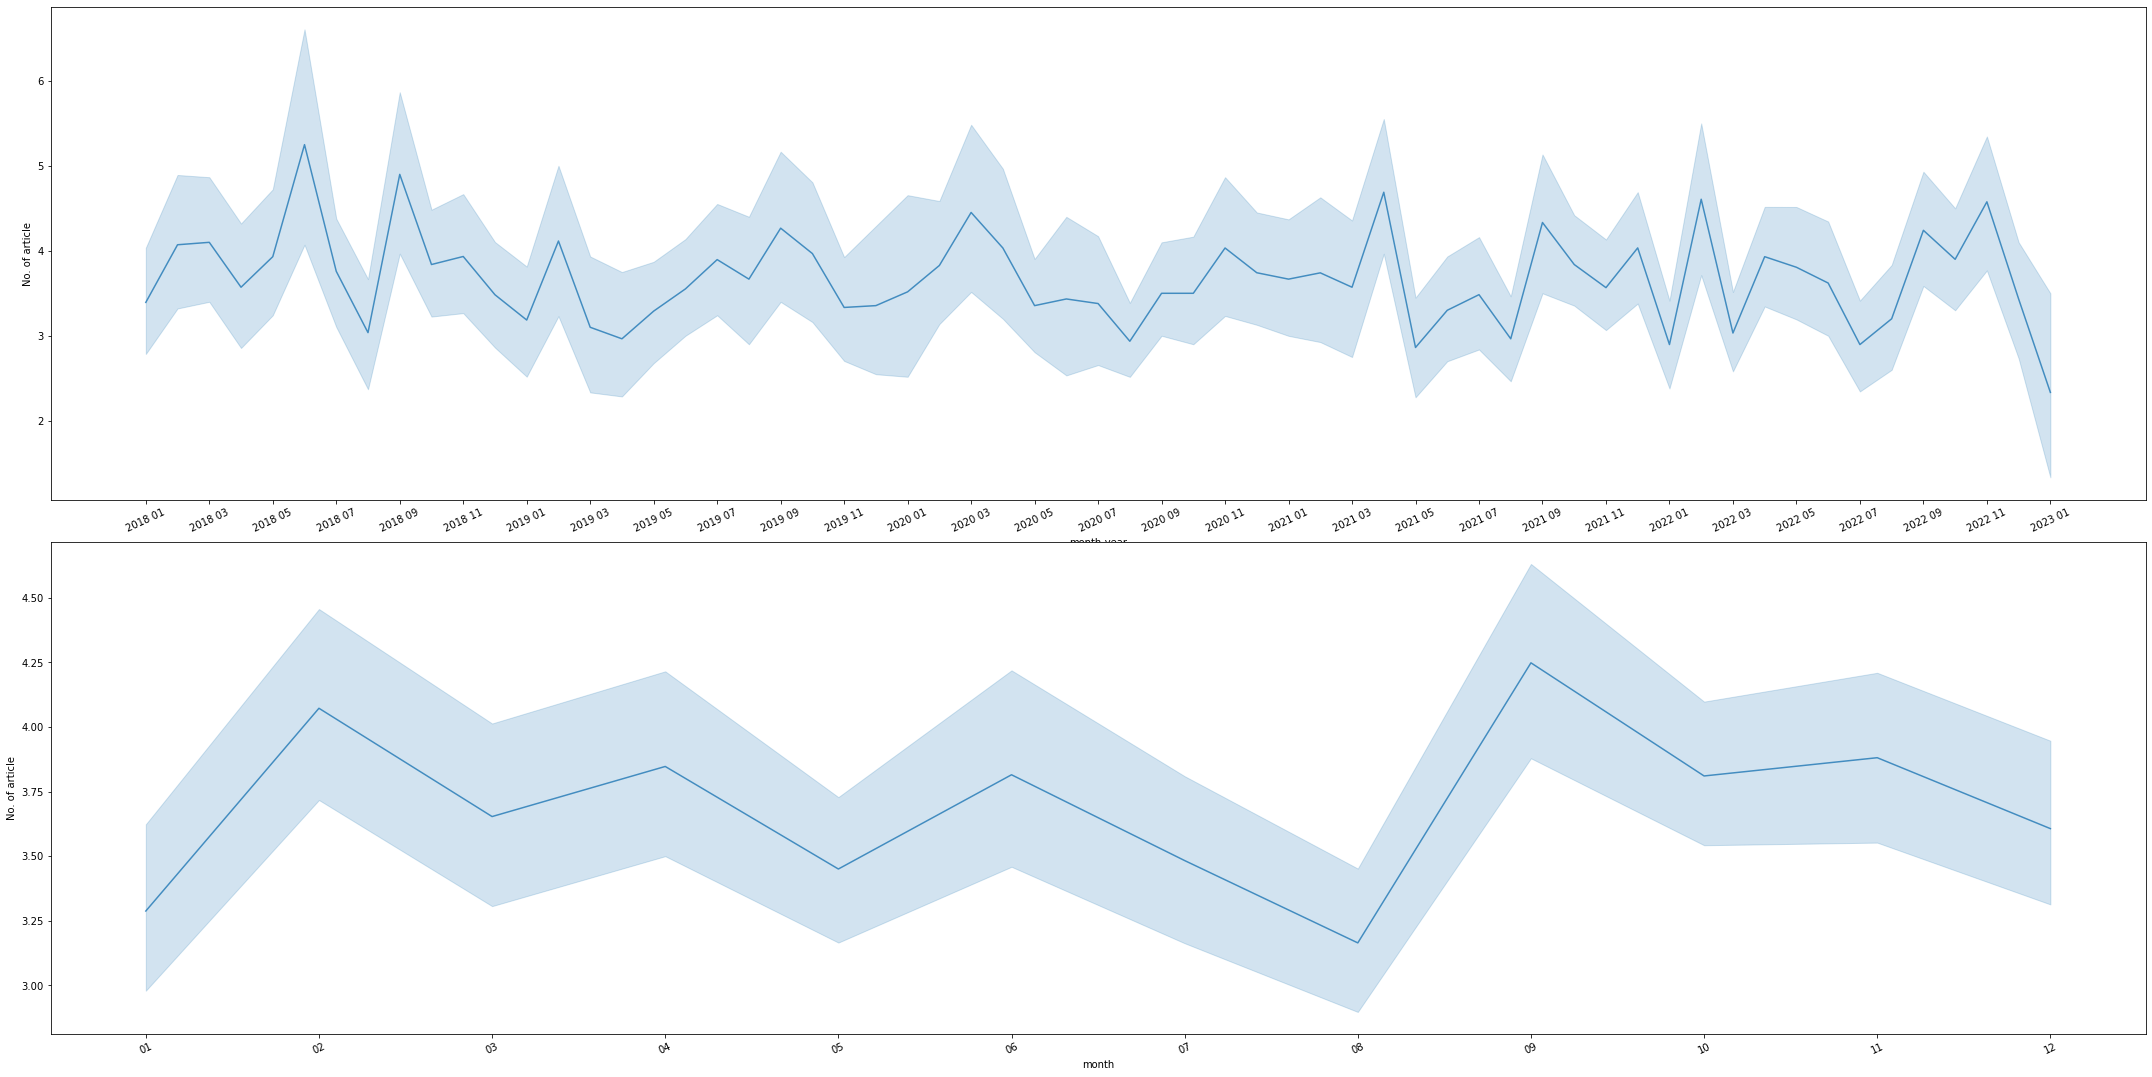

In [19]:
# TASK 5 - Show the evolution of the 'No. of articles? since 01.01.2018 until today
import seaborn as sns
%matplotlib inline

# Had to change the index and add some date columns for a easier handling
df_plot = df_date.reset_index()
df_plot = df_plot.rename_axis(None, axis=1)
df_plot['day'] = pd.to_datetime(df_plot['']).dt.to_period('D').dt.strftime('%d')
df_plot['month-year'] = pd.to_datetime(df_plot['']).dt.to_period('M').dt.strftime('%Y %m')
df_plot['month'] = pd.to_datetime(df_plot['']).dt.to_period('M').dt.strftime('%m')
df_plot['year'] = pd.to_datetime(df_plot['']).dt.to_period('Y').dt.strftime('%Y')

# Plot the data
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (30, 15))
sns.lineplot(x='month-year', y='No. of article', data=df_plot, ax=ax[0], alpha=0.8)
sns.lineplot(x='month', y='No. of article', data=df_plot, ax=ax[1], alpha=0.8)

# Style
plt.tight_layout()
ax[0].xaxis.set_tick_params(labelrotation=25)
ax[0].set_xticks(ax[0].get_xticks()[::2])
ax[1].xaxis.set_tick_params(labelrotation=25)

### Aufgabe 6
***
In der Aufgabe 6 identifiziere ich unübliche Ereignisse im zeitlichen Verlauf seit 01.01.2018

**Analyse:**

Es gibt auf den ersten Blick auf die Visualisierung eine höhere Anzahl Artikel im Sommer / Herbst 2018 als gewöhnlich.

Zusätzlich gibt es über alle Jahre hinweg gesehen, im September generell mehr Artikel als in anderen Monaten. Nach kurzen eigenen Recherchen kam ich auf den Entschluss,
dass die Abweichungen im September daher kommen, dass in diesem Zeitraum in Kanada Wahlen stattfinden.

### Aufgabe 7
***
In Aufgabe 7 zeige ich die ungewöhnlichen Ereignisse detailierter auf.  

**Challenge:** 
- Entscheidung, ob die Daten mit einem Diagramm oder einer Tabelle aufgezeigt werden sollen.
- Definierung, was ich genau darstellen möchte.

**Lösung:**
- Ich stelle die höhere Anzahl Artikel im Juni / September 2018 mit einem Balkendiagramm dar, da dieses Diagramm auf den ersten Blick die Unterschiede zu den restlichen Monaten aufzeigt.
- Ich möchte auf eine verstänldiche Art aufzeigen, dass in den Monaten Juni und September 2018 mehr Artikel als gewöhlnich über Justin Trudeau veröffentlicht wurden.

**Ergebnis:**
- Ein Balkendiagramm mit zusätzlichen Annotationen und einer Durchschnittslinie, welches die monatlichen Artikel im Jahr 2018 darstellt.

Text(6.8, 135, '')

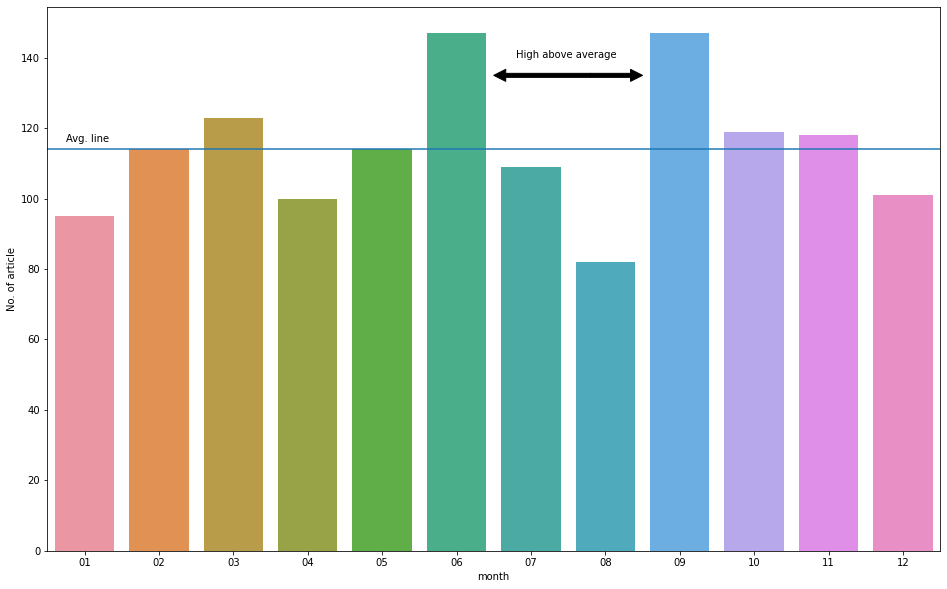

In [20]:
# TASK 7 - Show the unusual events

# I will concentrate me of the higher year 2018 and show the months, which are higher in average than the rest.

# Define a mask for 2018
mask_2018 = df_plot.loc[:, 'year'] == '2018'
df_plot_2018 = df_plot.loc[mask_2018, :]

# Create barchart for monthly visualisation
fig, ax1 = plt.subplots(figsize = (16, 10))
graph = sns.barplot( data = df_plot_2018, x = 'month', y = 'No. of article', ci = None, estimator = sum)

# Calculate the yearly average
mean_month = df_plot_2018.groupby('month')['No. of article'].sum().mean()

# Insert line with yearly average
graph = graph.axhline(mean_month)

# Insert text marker for high values and average
ax1.text(x = 5.8, y=140, s='High above average')
ax1.text(x = -0.25, y=116, s='Avg. line')

# Insert arrows for high values
ax1.annotate(text = '',
xy=[7.5, 135],
xytext=[6.8, 135],
arrowprops=dict(facecolor='black'))

ax1.annotate(text = '',
xy=[5.5, 135],
xytext=[6.8, 135],
arrowprops=dict(facecolor='black'))



### Aufgabe 8.1 (Tägliche Artikel)
***
In zeige die Ursache der erhöhten Anzahl an Artikeln auf.

**Challenge:** 
- Wie kann ich die Ursache definieren
- Wie kann ich die Ursache verständlich darstellen

**Lösung:**
- Ich extrahiere als erstes die Artikel vom Juni und vom September
- Ich nehme die Artikeltitel um im Text mögliche Gemeinsamkeiten in den definierten Zeitperioden zu finden. Weitere Anhaltspunkte liegen mir in diesem Datensatz nicht vor, ohne weitere Quellen zu analysieren. 
- Zur Veranschaulichung habe erstelle ich zwei Balkendiagramme, welche die tägliche Artikelanzahl darstellen. Dadurch können unter Umständen Datumsspezifische Ereignisse herausgefiltert werden. 

**Ergebnis:**
- Zwei Balkendiagramme, welche die tägliche Anzahl Artikel vom Juni und September 2018 darstellen.   

In [ ]:
# TASK 8 - Show the root cause of the unusual events in 2018 

df_extract = df_article.reset_index()
df_extract['webPublicationDate'] = pd.to_datetime(df_extract['webPublicationDate']).dt.strftime("%Y-%m-%d")

# Extract the articles from the two months high above average June
df_extract_june = df_extract[df_extract['webPublicationDate'].between('2018-05-31', '2018-07-01')]

# Extract the articles from the two months high above average Sept
df_extract_sept = df_extract[df_extract['webPublicationDate'].between('2018-08-31', '2018-10-01')]

# Create Plot
fig, ax2 = plt.subplots(nrows = 2, ncols = 1, figsize = (32,20))
df_extract_june.groupby('webPublicationDate')['webTitle'].count().plot(kind = 'bar', ax = ax2[0])
df_extract_sept.groupby('webPublicationDate')['webTitle'].count().plot(kind = 'bar', ax = ax2[1])



### Aufgabe 8.2 (Wortwolke)
***
Ich möchte analysieren, welche Themen und Wörter in dieser Periode im Titel am häufigsten vorkamen. 

**Challenge:** 
- Analyse des Textes, wie kann die Häufigkeit der Wörter dargestellt werden
- Welche Schlüsse kann ich aus der Häufigkeit ziehen. 

**Lösung:**
- Für die Darstellung des Textes erstelle ich eine Wortwolke, um die meist genannten Wörter auf den ersten Blick identifizieren zu können.
- Durch die meist gennnten Wörter kann ich identifizieren, zu welchen Themen es am meisten Artikel gab. Dies kann unter Umständen die Ursache der Ausreisser sein. 

**Ergebnis:**
- Zwei Wortwolken, welche die Häufigsten Wörter im Titel von den Artikeln aus Juni und September 2018 darstellen.

In [ ]:
# Define text for june
mask_title_june = df_extract_june.loc[:, 'webTitle'] 
text_june = str(df_extract_june.loc[:, 'webTitle'])

# Define text for sept
mask_title_sept = df_extract_sept.loc[:, 'webTitle'] 
text_sept = str(df_extract_sept.loc[:, 'webTitle'])

# Define unimportant words
words_stop = "to the of in a on ABC is and will justin trudeau for I Canada says fo - The after with like become Canadian"
words_stop_list = words_stop.split()
STOPWORDS.update(words_stop_list)

# Generate a word cloud image
wordcloud_june = WordCloud(background_color="white", width=1920, height=1080, min_word_length = 2, collocations=True).generate(text_june)
wordcloud_sept = WordCloud(background_color="white", width=1920, height=1080, min_word_length = 2, collocations=True).generate(text_sept)

# Show 
fig, ax = plt.subplots(figsize = (16,10))
plt.imshow(wordcloud_june, interpolation="bilinear")
#plt.imshow(wordcloud_sept, interpolation="bilinear")
plt.axis("off")
plt.show()

### Fazit
***
Die Wortwolke vom Juni zeigt auf, dass viele Artikel im Zusammenhang mit Donald Trump erstellt wurden und auch der G7 Gipfel wurde einige Male genannt. Nach einigen Recherchen fand ich heraus, dass sich Donald Trump und Justing Trudeau am G7 Gipfel nicht einigen konnten und es danach von beiden seiten zu medialer Aufmerksamkeit kam. 

Grundsätzlich könnten die Ergebnisse anhand des Artikelinhaltes, der Kategorien oder durch hinzuzug von weiteren Quellen, natürlich noch weiter vertieft und verfeinert werden. Jedoch gibt diese Lösung eine erste Übersicht über mögliche Ursachen und es kann darauf aufgebaut werden. 

Die Case Study war sehr interessant zu bearbeiten. Eine der grössten Challenges hatte ich gleich zu Beginn, als ich durch die verschiedenen Seiten iterieren musste, um alle Artikel zu sammeln und um die Limitierung von 200 Artikeln zu umgehen. Momentan benötigt das Programm ca. 165 Iterationen, was meiner Meinung nach zu viel ist. Sobald ich jedoch die Anzahl erhöht habe, hat die Abfrage an einem gewissen Zeitpunkt abgebrochen. Daher habe ich mich entschieden den "langsamen" aber dafür funktionalen Weg zu wählen. In der ganzen Case Study habe ich einige Programmierschritte und Kommentare absichtlich ein wenig ausführlicher gehalten, um meine Gedankengänge möglichst nachvollziehbar aufzuzeigen.   